<a href="https://colab.research.google.com/github/ababayato/Hamoye-Stage-E-Quiz/blob/main/Stage_E_Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Analysis & Forecast**<br>
**By Adedamola Babayato**<br>
**ID: 157372abee81f000**

In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller    
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

from datetime import datetime

In [2]:
# load dataset
url = 'https://raw.githubusercontent.com/ababayato/Hamoye-Stage-E-Quiz/main/Time_series_analysis_and_forecast_DATASET.csv'
df = pd.read_csv(url,index_col='FullDate',parse_dates=True)

In [3]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
print(df.shape)
df.isna().sum()

(92016, 4)


Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [5]:
df.describe(include='all')

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


Question 11

Resample the data from an hour sampling rate to a new sampling rate (i.e sum over the hours for each day). Which of the following is a plot of ElecPrice over time?

In [6]:
#downsample data points
df = df.resample('D').sum()
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-09-01 to 2021-02-28
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       3834 non-null   float64
 1   SysLoad    3834 non-null   float64
 2   GasPrice   3834 non-null   float64
 3   ElecPrice  3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


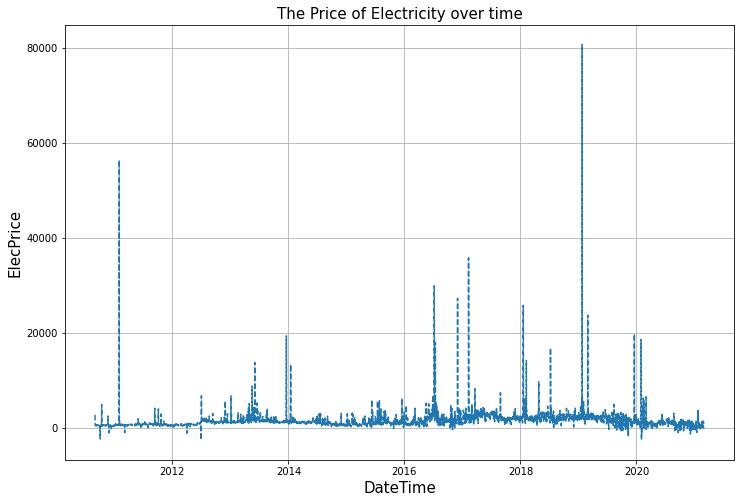

In [7]:
#plot of the new global_active_power over time
plt.figure(figsize=(12,8))
plt.plot(df.index, df.ElecPrice, '--')
plt.grid()
plt.xlabel('DateTime', fontsize = 15)
plt.ylabel('ElecPrice', fontsize = 15)
plt.title('The Price of Electricity over time', fontsize = 15)
plt.show()


Question 12

Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?

Question 13

Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?

In [8]:
def stationary_test(d_set):
  dftest = adfuller(d_set, autolag='AIC')
  adf = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lags', '# Observations'])

  for key, value in dftest[4].items():
    adf['Critical Value (%s)' %key] = value
  print(adf)

In [9]:
stationary_test(df.SysLoad)

Test Statistics           -3.690159
p-value                    0.004254
# Lags                    30.000000
# Observations          3803.000000
Critical Value (1%)       -3.432071
Critical Value (5%)       -2.862300
Critical Value (10%)      -2.567175
dtype: float64


In [10]:
stationary_test(df.GasPrice)

Test Statistics           -2.902767
p-value                    0.045027
# Lags                    27.000000
# Observations          3806.000000
Critical Value (1%)       -3.432069
Critical Value (5%)       -2.862300
Critical Value (10%)      -2.567174
dtype: float64


QUESTION 14 - 16 <br>
Using the new sampling rate (sum), divide the data into a train and test set. The first 2757 days is your train set and the last (x-2757) days is your test set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series model using the FullDate column as (‘dt’ or ‘ds’) and ElecPrice as ( ‘y’)

In [11]:
# reset index
df_new = df.reset_index()
df_new.head()


,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [12]:
# select columns for predictive model
data = df_new[['FullDate', 'ElecPrice']]

#rename columns to 'ds' and 'y' respectively
data = data.rename(columns={'FullDate':'ds', 'ElecPrice':'y'})

data.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [13]:
# assign train and test data
train = data[:2757]
test = data[2757:]

print(train.shape)
print(test.shape)

(2757, 2)
(1077, 2)


In [14]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

**Facebook Prophet Model Prediction**

In [15]:
model = Prophet() 

model.fit(train[['ds', 'y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
test_pred = test[['ds']]
prediction = model.predict(test_pred)

QUESTION 14

Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places? Hint:

Define a function that calculates the Mape using the definition of MAPE from the course Module and pass your dataset into it.

In [17]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test.y, prediction.yhat) * 100
print("The MAPE is :",round(mape,2))

The MAPE is : 549.48


Question 15

What is the RMSE in 2 decimal places?

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test.y, prediction.yhat))
print("The MAPE is :", round(rms,2))

The MAPE is : 3218.16


Question 16

If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?

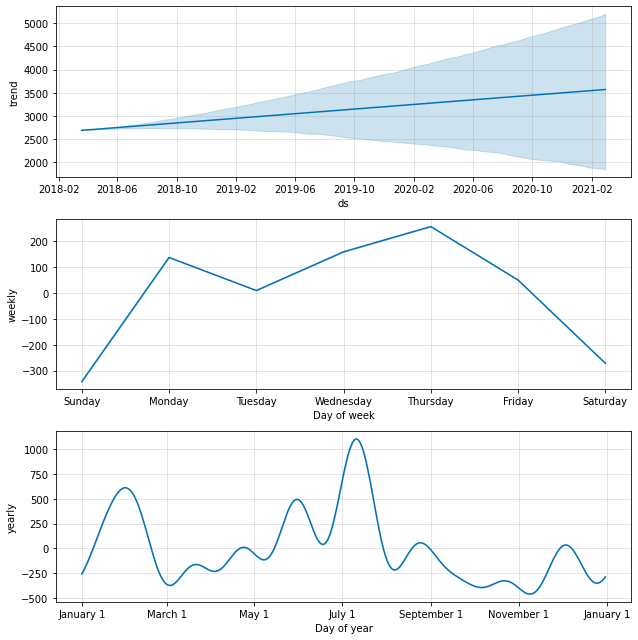

In [19]:
model.plot_components(prediction)
plt.show()

Questions 17-19

Multivariate Time Series Forecasting with Facebook Prophet

In the last exercise, we used only the dependent variable (ElecPrice) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last x-2757 days of ElecPrice.

In [20]:
df_new.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [21]:
df_new.reset_index(inplace=True)
df1 = df_new
print(df1.shape)
df1.head()

(3834, 6)


,index,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,0,2010-09-01,379.2,41565.380,88.56,2751.700
1,1,2010-09-02,369.6,38898.990,88.56,570.810
2,2,2010-09-03,439.2,41665.760,106.80,504.975
3,3,2010-09-04,328.8,35638.085,81.36,502.275
4,4,2010-09-05,357.6,35611.410,106.80,500.555


In [22]:
df1 = df1.rename(columns = {'FullDate':'ds',
                                    'ElecPrice':'y',
                                    'SysLoad':'add1',
                                     'Tmax':'add2',
                                    'GasPrice':'add3'})

In [23]:
train = df1[:2757]
test = df1[2757:]
print(train.shape)
print(test.shape)

(2757, 6)
(1077, 6)


In [24]:
model2 = Prophet(daily_seasonality=True)
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')
model2.fit(train)

Question 17

Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [25]:
y_pred = model2.predict(test)
y = np.array(test.y)
yp = np.array(y_pred.yhat)
MAPE = np.mean(((np.abs((y-yp)/y)))*100)
print(f'The Mean Average Percentage Error (MAPE) is: {round(MAPE, 2)}')

The Mean Average Percentage Error (MAPE) is: 232.77


Question 18

What is the RMSE in 2 decimal places?

In [26]:
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(y,yp))
print('The Root Mean Square Error (RMSE) value Is : {}'.format(round(rmse,2)))

The Root Mean Square Error (RMSE) value Is : 2708.4


Question 19

If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?

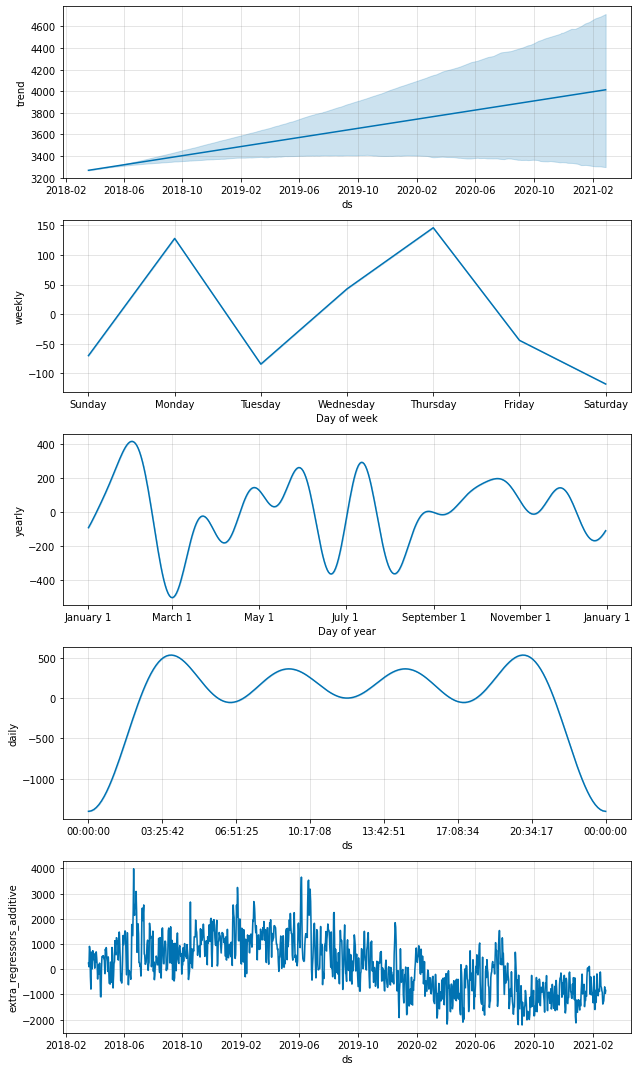

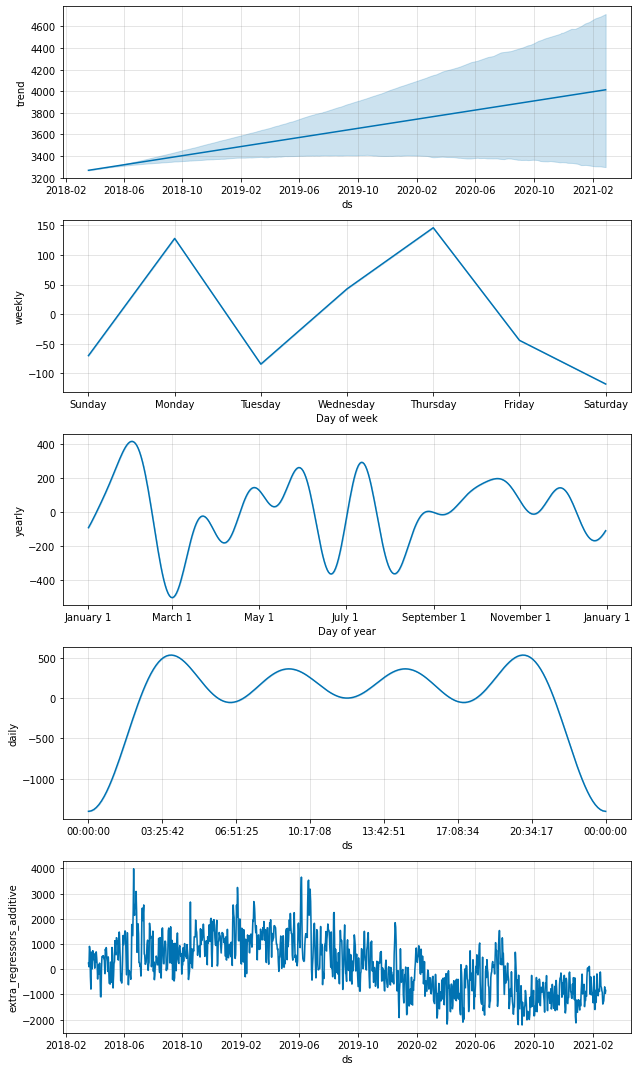

In [27]:
model2.plot_components(y_pred)

Question 20

Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),

What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?


In [28]:
# Dropping Tmax

df_new.head()

,index,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,0,2010-09-01,379.2,41565.380,88.56,2751.700
1,1,2010-09-02,369.6,38898.990,88.56,570.810
2,2,2010-09-03,439.2,41665.760,106.80,504.975
3,3,2010-09-04,328.8,35638.085,81.36,502.275
4,4,2010-09-05,357.6,35611.410,106.80,500.555


In [29]:
df2 = df_new.drop('Tmax', axis = 1)
df2.shape

(3834, 5)

In [30]:
df2 = df2.rename(columns = {'FullDate':'ds',
                                    'ElecPrice':'y',
                                    'SysLoad':'add1',
                                    'GasPrice':'add2'})

In [31]:
df2.head()

,index,ds,add1,add2,y
0,0,2010-09-01,41565.380,88.56,2751.700
1,1,2010-09-02,38898.990,88.56,570.810
2,2,2010-09-03,41665.760,106.80,504.975
3,3,2010-09-04,35638.085,81.36,502.275
4,4,2010-09-05,35611.410,106.80,500.555


In [32]:
train = df2[:2757]
test = df2[2757:]
print(train.shape)
print(test.shape)

(2757, 5)
(1077, 5)


In [33]:
model2 = Prophet(daily_seasonality=True)
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.fit(train)

In [34]:
# MAE
y_pred = model2.predict(test)
y = np.array(test.y)
yp = np.array(y_pred.yhat)
MAPE = np.mean(((np.abs((y-yp)/y)))*100)
print(f'The Mean Average Percentage Error (MAPE) is: {round(MAPE, 2)}')

The Mean Average Percentage Error (MAPE) is: 235.13
